In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')
from plotly import tools
# import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from IPython.display import HTML, Image
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#importing the libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import optuna
from platform import python_version
import sklearn
import tensorflow as tf
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import callbacks
from tensorflow.keras import backend as K
from keras.layers import LeakyReLU, ReLU
from sklearn.model_selection import KFold
from scipy.optimize import minimize, differential_evolution, LinearConstraint, NonlinearConstraint
import shap

##### Check version

In [3]:
#check versions
print(python_version())
print(optuna.__version__)
print(xgb.__version__)
print(sklearn.__version__)

3.9.7
3.0.2
1.6.1
1.1.1


##### Gather data from the .csv files for HTC and Pyrolysis.  Then process the data into features and labels.

In [4]:
filepath = 'Pyrolysis_data.csv'
data = pd.read_csv(filepath)
p_X = data.iloc[:,[0,1,2,3,5,6,7,8,9,10]]
p_y = data.iloc[:,11:19]
p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(p_X, p_y, test_size=0.2, random_state=100)

filepath = 'HTC_data.csv'
data = pd.read_csv(filepath)
h_X = data.iloc[:,1:11]
h_y = data.iloc[:,11:19]

# split into training and test data
h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(h_X, h_y, test_size=0.2, random_state=100)

## Technology type

In [12]:
p = True # select true for pyrolysis, false for HTC
c = True # True if CSI optimal solution is being used for the uncertainty analysis

#This code sets the X and y datasets used to either the pyrolysis or HTC data, depending on which dataset was selected in the above version.
if p:
    X = p_X
    y = p_y
else:
    X = h_X
    y = h_y

# Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

# R^2 Metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

#### Optuna trial code

Below is the code for the optuna trials.  Because Optuna is non-deterministic, optimal trial solutions found using this code will not result in the same hyperparamters reported in Table S3 and Table S4

In [13]:
# XGBoost model
## define an objective function
def xgb_objective(trial):
    kfold = KFold(n_splits=10, shuffle=True)
    r2_scores = []  
    
    for train, test in kfold.split(X, y):  
        X_train_shuf, y_train_shuf = X.iloc[train], y.iloc[train]
        X_test_shuf, y_test_shuf = X.iloc[test], y.iloc[test]
        
        subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1)
        max_depth = trial.suggest_int('max_depth', 4, 10)
        learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.3, 0.5])
        n_estimators = trial.suggest_int('n_estimators', 1000, 5000, step=1000)
        
        regressor_XGB=xgb.XGBRegressor(learning_rate = learning_rate,
                               n_estimators  = n_estimators,
                               max_depth   = max_depth,
                               subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_alpha = 0.00006,
                               scale_pos_weight=1,
                               eval_metric='rmse',
                               random_state = 101)
        XGB_model = MultiOutputRegressor(regressor_XGB)
        XGB_model.fit(X_train_shuf, y_train_shuf)

        predictions_XGB_test = XGB_model.predict(X_test_shuf)
        predictions_XGB_test = pd.DataFrame(predictions_XGB_test, columns = y_test_shuf.columns)
        
        score_test = r2_score(y_test_shuf, predictions_XGB_test)
        r2_scores.append(score_test)
        
    return np.mean(r2_scores)

In [14]:
def XGB_opt(X_train, y_train, X_test, y_test):
    ## study
    study = optuna.create_study(direction='maximize')
    study.optimize(xgb_objective, n_trials=60)

    trial = study.best_trial

    print('R2 score: {}'.format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))


    regressor_XGB=xgb.XGBRegressor(
                            learning_rate = trial.params['learning_rate'],
                            n_estimators  = trial.params['n_estimators'],
                            max_depth   = trial.params['max_depth'],
                            subsample = trial.params['subsample'],
                            colsample_bytree = trial.params['colsample_bytree'],
                            reg_alpha = 0.00006,
                            scale_pos_weight=1,
                            eval_metric=mean_squared_error)
    XGB_opt_model = MultiOutputRegressor(regressor_XGB)
    XGB_opt_model.fit(X_train, y_train)


    predictions_XGB_test = XGB_opt_model.predict(X_test)
    predictions_XGB_test = pd.DataFrame(predictions_XGB_test, columns = y_test.columns)
    score_test = r2_score(predictions_XGB_test, y_test)

    for i in range(8):
        print(f'The test score of column {y_test.columns[i]} is {r2_score(predictions_XGB_test.iloc[:,i], y_test.iloc[:,i])}')

    for i in range(8):
        print(f'The test RMSE of column {y_test.columns[i]} is {mean_squared_error(predictions_XGB_test.iloc[:,i], y_test.iloc[:,i], squared = False)})')

In [15]:
# RF model
## define an objective function
def rf_objective(trial):
    kfold = KFold(n_splits=10, shuffle=True)
    r2_scores = []  
    
    for train, test in kfold.split(X, y):  
        X_train_shuf, y_train_shuf = X.iloc[train], y.iloc[train]
        X_test_shuf, y_test_shuf = X.iloc[test], y.iloc[test]
        
        n_estimators = trial.suggest_int('n_estimators', 1, 500)
        max_features = trial.suggest_int('max_features', 1, 10)
        max_depth = trial.suggest_int('max_depth', 1, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 11)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 11)
        regressor_RF = RandomForestRegressor(n_estimators=n_estimators,
                                       max_features=max_features,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                        criterion="mse",
                                      random_state=101)
        model = MultiOutputRegressor(regressor_RF)
        model.fit(X_train_shuf, y_train_shuf)
        predictions_RF_test = model.predict(X_test_shuf)
        predictions_RF_test = pd.DataFrame(predictions_RF_test, columns = y_test_shuf.columns)
        score_test = r2_score(y_test_shuf, predictions_RF_test)
        r2_scores.append(score_test)
        
    return np.mean(r2_scores)

In [16]:
def RF_opt(X_train, y_train, X_test, y_test):
    # Using optuna to optimize the hyperparameters
    study = optuna.create_study(direction='maximize')
    study.optimize(rf_objective, n_trials=60)

    trial = study.best_trial

    print('R2 score: {}'.format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))

    regressor_RF=RandomForestRegressor(n_estimators= trial.params['n_estimators'], 
                                    max_features= trial.params['max_features'], 
                                    max_depth= trial.params['max_depth'], 
                                    min_samples_split= trial.params['min_samples_split'], 
                                    min_samples_leaf= trial.params['min_samples_leaf'], 
                                    random_state=101) # 7867
    model = MultiOutputRegressor(regressor_RF)
    model.fit(X_train, y_train)

    predictions_RF_test = model.predict(X_test)
    predictions_RF_test = pd.DataFrame(predictions_RF_test, columns = y_test.columns)
    score_test = r2_score(predictions_RF_test, y_test)

    for i in range(8):
        print(f'The test score of column {y_test.columns[i]} is {r2_score(predictions_RF_test.iloc[:,i], y_test.iloc[:,i])}')

    for i in range(8):
        print(f'The test RMSE of column {y_test.columns[i]} is {mean_squared_error(predictions_RF_test.iloc[:,i], y_test.iloc[:,i], squared = False)})')

In [17]:
def dnn_objective(trial):
   
    # Prepare cross validation
    kfold = KFold(n_splits=10, shuffle=True)
   
    r2_scores = []  # List to store R^2 score for each fold
   
    for train, test in kfold.split(X, y):  # assuming your data is in X and y
        X_train_shuf, y_train_shuf = X.iloc[train], y.iloc[train]
        X_test_shuf, y_test_shuf = X.iloc[test], y.iloc[test]
        # Define Keras model
        model = Sequential()
        n_layers = trial.suggest_int('n_layers', 1, 5)

        for i in range(n_layers):
            num_hidden = trial.suggest_int('n_units_layer{}'.format(i), 1, 768, log=True)
            activation = trial.suggest_categorical('activation_{}'.format(i), ['relu', 'sigmoid', 'tanh', 'LeakyReLU'])

            if i == 0:
                model.add(Dense(num_hidden, kernel_initializer='uniform', activation=activation, input_dim=10))  # assuming input_dim=10
            else:
                model.add(Dense(num_hidden, activation=activation))

        model.add(Dense(8, activation='linear'))  # output layer

        # Compile model
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
        opt = Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='mse', metrics=[r_squared, 'mse'])  # r_squared is the custom R^2 function defined before
       
        # Fit model
        history = model.fit(X_train_shuf, y_train_shuf, batch_size = 32, epochs = 500, 
                        validation_data=(X_test_shuf, y_test_shuf), verbose=0, callbacks=[early_stopping])  # assuming early_stopping is already defined

        # Evaluate model
        
        predictions_DNN_test = model.predict(X_test_shuf)
        predictions_DNN_test = pd.DataFrame(predictions_DNN_test, columns = y_test_shuf.columns)
        score_test = r2_score(y_test_shuf, predictions_DNN_test)
        r2_scores.append(score_test)
       
    return np.mean(r2_scores)


In [18]:
def DNN_opt(X_train, y_train, X_test, y_test):
    ## Start hyperparameters tuning using optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(dnn_objective, n_trials=60)

    trial = study.best_trial

    print('R2 score: {}'.format(trial.value))
    print("Best hyperparameters: {}".format(trial.params))

    ## model after parameters tuning
    DNN_opt_model = Sequential()
    DNN_opt_model.add(Dense(units = trial.params['n_units_layer0'], activation = trial.params['activation_0'], input_dim = 10))

    if trial.params['n_layers'] > 1:
        DNN_opt_model.add(Dense(units = trial.params['n_units_layer1'], activation = trial.params['activation_1']))
    if trial.params['n_layers'] > 2:
        DNN_opt_model.add(Dense(units = trial.params['n_units_layer2'], activation = trial.params['activation_2']))
    if trial.params['n_layers'] > 3:
        DNN_opt_model.add(Dense(units = trial.params['n_units_layer3'], activation = trial.params['activation_3']))
    if trial.params['n_layers'] > 4:
        DNN_opt_model.add(Dense(units = trial.params['n_units_layer4'], activation = trial.params['activation_4']))


    DNN_opt_model.add(Dense(units = 8, activation = 'linear'))
    opt = Adam(learning_rate=trial.params['lr'])
    DNN_opt_model.compile(optimizer = opt, loss = 'mse', metrics=[r_squared, 'mse'])
    history = DNN_opt_model.fit(X_train, y_train, batch_size = 32, epochs = 500,validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

    # using model with optimized parameters to predict
    predictions_DNN_test = DNN_opt_model.predict(X_test)
    predictions_DNN_test = pd.DataFrame(predictions_DNN_test, columns = y_test.columns)
    score_test = r2_score(predictions_DNN_test, y_test)

    for i in range(8):
        print(f'The test score of column {y_test.columns[i]} is {r2_score(predictions_DNN_test.iloc[:,i], y_test.iloc[:,i])}')

    for i in range(8):
        print(f'The test RMSE of column {y_test.columns[i]} is {mean_squared_error(predictions_DNN_test.iloc[:,i], y_test.iloc[:,i], squared = False)})')

### Running Optuna Trials - S3-S4


In [24]:
'''Uncomment the trials that you wish to run'''

#HTC
#XGB_opt(h_X_train, h_y_train, h_X_test, h_y_test)
#RF_opt(h_X_train, h_y_train, h_X_test, h_y_test)
#DNN_opt(h_X_train, h_y_train, h_X_test, h_y_test)

# pyrolysis
#XGB_opt(p_X_train, p_y_train, p_X_test, p_y_test)
RF_opt(p_X_train, p_y_train, p_X_test, p_y_test)
#DNN_opt(p_X_train, p_y_train, p_X_test, p_y_test)

[I 2023-07-19 08:50:38,114] A new study created in memory with name: no-name-0ec2142a-6045-4aff-8473-4fd700c2344e
[I 2023-07-19 08:51:30,558] Trial 0 finished with value: 0.765958718398081 and parameters: {'n_estimators': 489, 'max_features': 10, 'max_depth': 88, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.765958718398081.
[I 2023-07-19 08:52:04,153] Trial 1 finished with value: 0.8245275101579349 and parameters: {'n_estimators': 318, 'max_features': 6, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8245275101579349.
[I 2023-07-19 08:52:09,595] Trial 2 finished with value: 0.7958693969464181 and parameters: {'n_estimators': 60, 'max_features': 4, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8245275101579349.
[I 2023-07-19 08:52:28,927] Trial 3 finished with value: 0.7264360837316384 and parameters: {'n_estimators': 256, 'max_features': 2, 'max_depth': 57,

R2 score: 0.8589876662568056
Best hyperparameters: {'n_estimators': 30, 'max_features': 3, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1}
The test score of column Yield_char (%) is 0.8848429086054845
The test score of column C_char (%) is 0.9451500301951765
The test score of column H_char (%) is 0.8245715688458277
The test score of column O_char (%) is 0.8724289900513464
The test score of column N_char (%) is 0.9363171598592425
The test score of column Char_HHV is 0.8244862111259328
The test score of column ER is 0.7531198895691602
The test score of column CR is 0.8044920483444091
The test RMSE of column Yield_char (%) is 4.233079664167528)
The test RMSE of column C_char (%) is 3.15465585935914)
The test RMSE of column H_char (%) is 0.4837383577518897)
The test RMSE of column O_char (%) is 3.2093223214687705)
The test RMSE of column N_char (%) is 0.22622916047985228)
The test RMSE of column Char_HHV is 2.2705150264483147)
The test RMSE of column ER is 6.078209026047578

### Optimal models code

##### XGB

In [19]:
def optimal_XGB(X_train, y_train, X_test, y_test, params):
    regressor_XGB=xgb.XGBRegressor(
                            learning_rate = params[3],
                            n_estimators  = params[4],
                            max_depth   = params[0],
                            subsample = params[2],
                            colsample_bytree = params[1],
                            reg_alpha = 0.00006,
                            scale_pos_weight=1,
                            eval_metric=mean_squared_error)
    XGB_opt_model = MultiOutputRegressor(regressor_XGB)
    XGB_opt_model.fit(X_train, y_train)

    predictions_XGB_test = XGB_opt_model.predict(X_test)
    predictions_XGB_test = pd.DataFrame(predictions_XGB_test, columns = y_test.columns)
    score_test = r2_score(predictions_XGB_test, y_test)

    print("XGB")

    for i in range(8):
        print('The test score of column {} is {}'.format(y_test.columns[i], r2_score(predictions_XGB_test.iloc[:,i], y_test.iloc[:,i])))

    for i in range(8):
        print('The test RMSE of column {} is {}'.format(y_test.columns[i], mean_squared_error(predictions_XGB_test.iloc[:,i], y_test.iloc[:,i], squared = False)))

    return XGB_opt_model

##### RF

In [20]:
def optimal_RF(X_train, y_train, X_test, y_test, params):
    regressor_RF=RandomForestRegressor(n_estimators= params[0], 
                                    max_features= params[1], 
                                    max_depth= params[2], 
                                    min_samples_split= params[3], 
                                    min_samples_leaf= params[4], 
                                    random_state=101) # 7867
    RF_opt_model = MultiOutputRegressor(regressor_RF)
    RF_opt_model.fit(X_train, y_train)

    predictions_RF_test = RF_opt_model.predict(X_test)
    predictions_RF_test = pd.DataFrame(predictions_RF_test, columns = y_test.columns)
    score_test = r2_score(predictions_RF_test, y_test)

    print("RF")

    for i in range(8):
        print('The test score of column {} is {}'.format(y_test.columns[i], r2_score(predictions_RF_test.iloc[:,i], y_test.iloc[:,i])))

    for i in range(8):
        print('The test RMSE of column {} is {}'.format(y_test.columns[i], mean_squared_error(predictions_RF_test.iloc[:,i], y_test.iloc[:,i], squared = False)))

    return RF_opt_model

##### DNN

In [21]:
def optimal_DNN(X_train, y_train, X_test, y_test, params):
    DNN_opt_model = Sequential()

    DNN_opt_model.add(Dense(units = params[1], kernel_initializer='uniform', activation = params[4], input_dim = 10))
    DNN_opt_model.add(Dense(units = params[2], activation = params[5]))
    DNN_opt_model.add(Dense(units = params[3], activation = params[6]))
    DNN_opt_model.add(Dense(units = 8, activation = 'linear'))
    opt = Adam(learning_rate=params[0])
    DNN_opt_model.compile(optimizer = opt, loss = 'mse', metrics=[r_squared, 'mse'])
    history =DNN_opt_model.fit(X_train, y_train, batch_size = 32, validation_data=(X_test, y_test), verbose = 0, epochs = 500, callbacks=[early_stopping])

    predictions_DNN_test = DNN_opt_model.predict(X_test)
    predictions_DNN_test = pd.DataFrame(predictions_DNN_test, columns = y_test.columns)
    score_test = r2_score(predictions_DNN_test, y_test)

    print("DNN")

    for i in range(8):
        print('The test score of column {} is {}'.format(y_test.columns[i], r2_score(predictions_DNN_test.iloc[:,i], y_test.iloc[:,i])))

    for i in range(8):
        print('The test RMSE of column {} is {}'.format(y_test.columns[i], mean_squared_error(predictions_DNN_test.iloc[:,i], y_test.iloc[:,i], squared = False)))

    return DNN_opt_model

### Code for Table S5-S6, Fig 3., Fig. 4

In [22]:
#these are the optimal hyperparameter identified during an optuna trial and reported in Table S3 and S4.  
# Please refer to the tables in the paper for the column heading for each of the parameters
h_xgb_params = [3, .5, .8, .01, 5000]
h_rf_params = [92, 2, 48, 2, 1]
h_dnn_params = [.001, 672, 224, 480, 'LeakyReLU', 'ReLU', 'LeakyReLU']
p_xgb_params = [4, .6, .6, .01, 3000]
p_rf_params = [100, 6, 16, 2, 1]
p_dnn_params = [.000358, 415, 679, 282, 'LeakyReLU', 'ReLU', 'LeakyReLU']

print("Pyrolysis")
p_opt_XGB = optimal_XGB(p_X_train, p_y_train, p_X_test, p_y_test, p_xgb_params)
p_opt_RF = optimal_RF(p_X_train, p_y_train, p_X_test, p_y_test, p_rf_params)
p_opt_DNN = optimal_DNN(p_X_train, p_y_train, p_X_test, p_y_test, p_dnn_params)

print("HTC")
h_opt_XGB = optimal_XGB(h_X_train, h_y_train, h_X_test, h_y_test, h_xgb_params)
h_opt_RF = optimal_RF(h_X_train, h_y_train, h_X_test, h_y_test, h_rf_params)
h_opt_DNN = optimal_DNN(h_X_train, h_y_train, h_X_test, h_y_test, h_dnn_params)

Pyrolysis
XGB
The test score of column Yield_char (%) is 0.9373907052076876
The test score of column C_char (%) is 0.9806448346312376
The test score of column H_char (%) is 0.9184176543296934
The test score of column O_char (%) is 0.8951628085735539
The test score of column N_char (%) is 0.9335559156881511
The test score of column Char_HHV is 0.8809580613340434
The test score of column ER is 0.6877782356201139
The test score of column CR is 0.8792999874255543
The test RMSE of column Yield_char (%) is 3.5302740947490587
The test RMSE of column C_char (%) is 2.0504959685201762
The test RMSE of column H_char (%) is 0.37602793757767167
The test RMSE of column O_char (%) is 3.140153966521116
The test RMSE of column N_char (%) is 0.227617947447542
The test RMSE of column Char_HHV is 1.9806617023981103
The test RMSE of column ER is 7.8265221454589415
The test RMSE of column CR is 5.173733178784443
RF
The test score of column Yield_char (%) is 0.9009704210779682
The test score of column C_char

### Shap - Figure 5

100%|██████████| 92/92 [10:44<00:00,  7.00s/it]


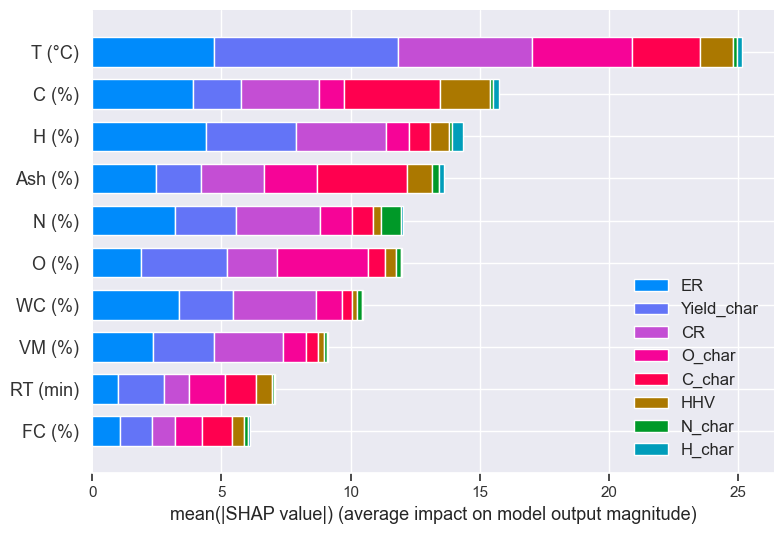

100%|██████████| 74/74 [05:56<00:00,  4.82s/it]


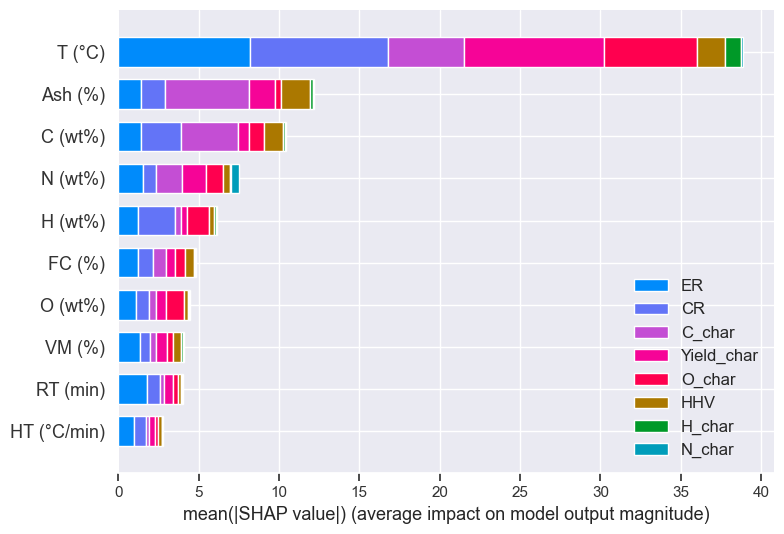

In [26]:
#HTC
explainer = shap.KernelExplainer(h_opt_XGB.predict, h_X_test)
shap_values = explainer.shap_values(h_X_test)
shap.summary_plot(shap_values, h_X_test, class_names = ['Yield_char', 'C_char', 'H_char', 'N_char', 'O_char', 'HHV','ER', 'CR'])

#Pyrolysis
explainer = shap.KernelExplainer(p_opt_XGB.predict, p_X_test)
shap_values = explainer.shap_values(p_X_test)
shap.summary_plot(shap_values, p_X_test, class_names = ['Yield_char', 'C_char', 'H_char', 'O_char', 'N_char', 'HHV','ER', 'CR'])

### Pareto Front - Fig. 6

In [23]:
def my_model(FW_C):
    # Your model code here
    if p:
        model  = p_opt_XGB.predict(FW_C)
    else:
        model  = h_opt_XGB.predict(FW_C)
    return model 

# Define the objectives and constraints
def f1(x):
    inputs = x.reshape(1, -1)
    outputs = my_model(inputs)

    #these equations differ due to the different orders of output for the labels
    if p:
        return outputs[:, 7] - (outputs[:, 2]/ outputs[:, 1]*12 + outputs[:, 3]/ outputs[:, 1]*12/16 + outputs[:, 4]/ outputs[:, 1]*12/14) / 3 * outputs[:, 0]
    else:
        return outputs[:, 7] - (outputs[:, 2]/ outputs[:, 1]*12 + outputs[:, 3]/ outputs[:, 1]*12/14 + outputs[:, 4]/ outputs[:, 1]*12/16) / 3 * outputs[:, 0]

# ORDER OF VALUES FOR INPUTS AND OUTPUTS
#                   0           1           2           3       4           5       6  7
#y pyrolysis:  Yield_char (%),C_char (%),H_char (%),O_char (%),N_char (%),Char_HHV,ER,CR
#              0          1         2           3         4          5           6      7
#y htc: Char_yield (%),Char_C (%),Char_H (%),Char_N (%),Char_O (%),HHV (MJ/kg),ER (%),CR (%)
#          0    1     2     3      4     5       6     7       8       9
#x htc: C (%),H (%),N (%),O (%),WC (%),VM (%),FC (%),Ash (%),T (°C),RT (min)
#                 0        1      2       3     4     5       6       7      8          9
#x pyrolysis: C (wt%),H (wt%),N (wt%),O (wt%),FC (%),VM (%),Ash (%),T (°C),RT (min),HT (°C/min)

# REI = HHV/(0.75 * (Power * time) + mH2O*(H^T_H2O-25) + mbiomass * 5.34t^2-299t - 5.34*298^2-299*298

def f2(x):
    inputs = x.reshape(1, -1)
    outputs = my_model(inputs)

    if p:
        #print("x array", x)
        power = 1 #kW
        time = (inputs[:, 8] + (inputs[:, 7] - 25)/inputs[:, 9]) * 60 # seconds
        Q_e = power * time # KJ


        m_biomass = 1 #kg
        m_h2o = 0.05 #kg
        Q_p_biomass = m_biomass*(2.67*((273+inputs[:, 7])**2-298**2) - 299*(273+inputs[:, 7]-298))/1000 + m_h2o * 40.65 * 1000/18#, specific heat is 5.34 kJ/kg/degree C, but is divided by 2 during integration yields kJ , 1000/18 moles water per kg, yields 113 KJ
        #print("q_p_biomass (KJ)", Q_p_biomass)

        Q_p_h2o = m_h2o * 4.186 * (inputs[:, 7] - 25)  #unitless * kg * kj/mol * mol/kg, 4.186 kJ/kg/degree C
        #print("q_p_h2o (KJ)", Q_p_h2o)

        Q_p = Q_p_h2o + Q_p_biomass # KJ  + KJ = KJ
        

        Q_c = 1000*outputs[:, 5] # KJ/kg
        #print("Q_c (KJ/kg)", Q_c)

        rei = Q_c/(0.75*Q_e+Q_p)
        #print("REI (1/kg)", rei)
        #print("old objective", outputs[:, 5] * 1000 / (45 * (inputs[:, 8] + (inputs[:, 7] - 25)/inputs[:, 9] ) + 113 + (inputs[:, 7] - 25) * (4.186 * 0.05 + 0.00267 * inputs[:, 7] + 1.22557) ))
        #print("Q_e (KJ)", Q_e)
        #print("old Q_e", 60*(inputs[:, 8] + (inputs[:, 7] - 25)/inputs[:, 9] ))
        #print("Q_p (KJ)", Q_p)
        #print("old Q_p", (113 + (inputs[:, 7] - 25) * (4.186 * 0.05 + 0.00267 * inputs[:, 7] + 1.22557)))
        #print("new denominator", (0.75*Q_e+Q_p))
        #print("old denominator", (45 * (inputs[:, 8] + (inputs[:, 7] - 25)/inputs[:, 9] ) + 113 + (inputs[:, 7] - 25) * (4.186 * 0.05 + 0.00267 * inputs[:, 7] + 1.22557) ))

        return outputs[:, 5] * 1000 / (45 * (inputs[:, 8] + (inputs[:, 7] - 25)/inputs[:, 9] ) + 113 + (inputs[:, 7] - 25) * (4.186 * 0.05 + 0.00267 * inputs[:, 7] + 1.22557) )
    else:
        power = 1 #kW
        time = inputs[:, 9] *60 #seconds
        Q_e = power * time #KJ
        #print("Q_e", Q_e)

        m_biomass = 1 #kg
        Q_p_biomass = m_biomass*(2.67*((273+inputs[:, 8])**2-298**2) - 299*(273+inputs[:, 8]-298))/1000 #specific heat is 2.67 kJ/kg/degree C, yields kJ
        #print("q_p_biomass", Q_p_biomass)

        m_h2o = inputs[:, 4]/(100-inputs[:, 4])*m_biomass #kg water/kg biomass * 100/(100- kg water/kg biomass) yields kg water ????
        Q_p_h2o = m_h2o * 4.186 * (inputs[:, 8] - 25)  #unitless * kg * kj/mol * mol/kg, 4.186 kJ/kg/degree C
        #print("q_p_h2o", Q_p_h2o)

        Q_p = Q_p_h2o + Q_p_biomass # KJ  + KJ = KJ
        #print("Q_p", Q_p)

        Q_c = 1000*outputs[:, 5] # KJ/kg
        #print("Q_c", Q_c)

        rei = Q_c/(0.75*Q_e+Q_p)
        #print("REI", rei)
        #print("old objective", (outputs[:, 5]+10) * 1000 / (45 * inputs[:, 9] + (inputs[:, 8] - 25) * (4.186 * inputs[:, 4] / (100 - inputs[:, 4]) + 0.00267 * inputs[:, 8] + 1.22557)))
        #print("denominator", (0.75*Q_e+Q_p))
        #print("old denominator", (45 * inputs[:, 9] + (inputs[:, 8] - 25) * (4.186 * inputs[:, 4] / (100 - inputs[:, 4]) + 0.00267 * inputs[:, 8] + 1.22557)))

        # The number 10 in the numerator serves as an empirical correction factor. 
        # It assists in adjusting the model's predictions to more closely match observed or expected values for the HHV of the char produced during the HTC process, accounting for the model's limitations.
        return (outputs[:, 5]+10) * 1000 / (45 * inputs[:, 9] + (inputs[:, 8] - 25) * (4.186 * inputs[:, 4] / (100 - inputs[:, 4]) + 0.00267 * inputs[:, 8] + 1.22557))

def c1(x):
    return x[0] + x[1] + x[2] + x[3] + x[7] - 100 - 2

def c2(x):
    return -x[0] - x[1] - x[2] - x[3] - x[7] + 100 - 2

def c3(x):
    return x[5] + x[6] + x[7] - 100 - 2

def c4(x):
    return -x[5] - x[6] - x[7] + 100 - 2

def c_f2(x):
    # Compute the secondary objective
    f2_value = f2(x)
    # Return the constraint value
    return f2_value - f2_max

def c_f1(x):
    # Compute the secondary objective
    f1_value = f1(x)
    # Return the constraint value
    return f1_value - f1_max


# Define the epsilon penalty function
def epsilon_penalty_f2(x):
    # Compute the secondary objective
    f2_value = f2(x)
    # Compute the epsilon penalty
    if f2_value > f2_max:
#         return epsilon * (f2_value - f2_max)
        return 0
    else:
#         return 0
        return epsilon * (f2_value)

# Define the epsilon penalty function
def epsilon_penalty_f1(x):
    # Compute the secondary objective
    f1_value = f1(x)
    # Compute the epsilon penalty
    if f1_value > f1_max:
        return 0
#         return epsilon * (f1_value - f1_max)
    else:
        return epsilon * (f1_value)

    
# Define the optimization problem
def opt_f2(x):
    f1_value = f1(x)
    f2_value = f2(x)
    return -(f1_value + epsilon_penalty_f2(x))

def opt_f1(x):
    f1_value = f1(x)
    f2_value = f2(x)
    return -(f2_value + epsilon_penalty_f1(x))

#### Multi-objective optimization - Table 4

This section of code yields the 6 points on the optimal pareto front.  To change technologies, change the boolean p in the Technology Type Section

In [24]:
# # Define the bounds
if p:
    #                 0          1           2            3             4            5              6        7            8          9
    #x pyrolysis: C (wt%),   H (wt%),     N (wt%),     O (wt%),       FC (%),     VM (%),       Ash (%),   T (°C),    RT (min), HT (°C/min)
    bounds = [(53.9, 53.9), (8.9, 8.9), (1.7, 1.7), (33.7, 33.7), (13.8, 13.8), (84.8, 84.8), (1.4, 1.4), (200, 500), (10, 120), (2.5, 20)]

    # Set the upper bound for the secondary objective
    maxes = [50, 13.6, 13.1, 12.6, 12.2, 20] #the first entry in this is for HC1, with f1_max.  The other entriest are for HC2-6 with F2 max

    # Define the epsilon values
    epsilons = [1, 9, 6, 3, 2, .001] #the first entry in this is for HC1, with f1_max.  The other entriest are for HC2-6 with F2 max
else:
    #           0                1          2              3         4              5               6           7           8       9
    #x htc:    C (%),          H (%),       N (%),     O (%),       WC (%),      VM (%),        FC (%),     Ash (%),     T (°C),    RT (min)
    bounds = [(53.9, 53.9), (8.9, 8.9), (1.7, 1.7), (33.7, 33.7), (50.4, 96), (84.8, 84.8), (13.8, 13.8), (1.4, 1.4), (180, 250), (30, 240)]

    # Set the upper bound for the secondary objective
    maxes =  [55, 12, 10, 9, 8, 20]  #the first entry in this is for HC1, with f1_max.  The other entriest are for HC2-6 with F2 max

    # Define the epsilon values
    epsilons = [0.001, 4.5, 9, 2.8, 2.4, 0.001] #the first entry in this is for HC1, with f1_max.  The other entriest are for HC2-6 with F2 max

solutions = []
res_x = []
for i in range(len(epsilons)): 
    print(i)
    # set maximum values on parameters
    if i == 0:
        f1_max = maxes[i]
    else:
        f2_max = maxes[i]

    #set epsilon values
    epsilon = epsilons[i]

    #solve the optimization problem, which differs for HC1 than the rest of the problems
    # no seed was used initially to produce the results in the manuscript.  The seed was later added to aid reproducability.
    if i ==0:
        res = differential_evolution(opt_f1, bounds, args=(), tol=1e-2, mutation=(0.5, 1), recombination=0.7, strategy='best1bin', popsize=15, maxiter=1000, seed=2410, callback=None, disp=False, polish=True, init='latinhypercube', atol=0)
    else:
        res = differential_evolution(opt_f2, bounds, args=(), tol=1e-2, mutation=(0.5, 1), recombination=0.7, strategy='best1bin', popsize=15, maxiter=1000, seed=2410, callback=None, disp=False, polish=True, init='latinhypercube', atol=0)

    res_x.append(res.x) #(C, H, N, O, FC, VM, Ash, T, RT, HT)
    solutions.append((f1(res.x), f2(res.x)))    

for j in range(len(solutions)):
    print(solutions[j]) #(C, H, N, O, FC, VM, Ash, T, RT, HT)

for j in range(len(solutions)): 
    print(res_x[j]) #(C, H, N, O, FC, VM, Ash, T, RT, HT)

0
1
2
3
4
5
(array([49.322536], dtype=float32), array([13.94631158]))
(array([55.309597], dtype=float32), array([13.59621545]))
(array([57.329227], dtype=float32), array([13.09607433]))
(array([57.352592], dtype=float32), array([12.59907185]))
(array([58.017136], dtype=float32), array([12.19838914]))
(array([58.017136], dtype=float32), array([12.07256201]))
[ 53.9          8.9          1.7         33.7         13.8
  84.8          1.4        262.55239375  10.06190424  19.85477948]
[ 53.9          8.9          1.7         33.7         13.8
  84.8          1.4        316.38025889  10.53726873  19.46281062]
[ 53.9          8.9          1.7         33.7         13.8
  84.8          1.4        315.95227886  10.33701352  17.31771886]
[ 53.9          8.9          1.7         33.7         13.8
  84.8          1.4        318.34279366  10.86479478  16.42353545]
[ 53.9          8.9          1.7         33.7         13.8
  84.8          1.4        316.59677997  10.11655725  14.40633928]
[ 53.9    

#### Single objective optimization

This section of code is used to test the objective functions, and does not generate results for the paper.

In [ ]:
bounds = [(53.9, 53.9), (8.9, 8.9), (1.7, 1.7), (33.7, 33.7), (13.8, 13.8), (84.8, 84.8), (1.4, 1.4), (200, 500), (10, 120), (2.5, 20)]
res_x = []
solutions = []
print(bounds)

for i in range(2):
    if i == 0:
        rei_obj = True
    else:
        rei_obj = False

    # Define the optimization problem
    def opt_single_obj(x):
        if not rei_obj:
            return 0-f1(x) #CSI
        else:
            return 0-f2(x) #REI
        
    res = differential_evolution(opt_single_obj, bounds, args=(), tol=1e-2, mutation=(0.5, 1), recombination=0.7, strategy='best1bin', popsize=15, maxiter=1000, seed=2410, callback=None, disp=False, polish=True, init='latinhypercube', atol=0)

    res_x.append(res.x) #(C, H, N, O, FC, VM, Ash, T, RT, HT)
    solutions.append((f1(res.x), f2(res.x)))    

for j in range(len(solutions)):
    print(solutions[j]) #(C, H, N, O, FC, VM, Ash, T, RT, HT)

for j in range(len(solutions)): 
    print(res_x[j]) #(C, H, N, O, FC, VM, Ash, T, RT, HT)

### Monte Carlo Simulation

In [25]:
def generate_lognormal_samples(mean, sd, size):
    # Calculate the parameters of the underlying normal distribution
    mu = np.log(mean**2 / np.sqrt(sd**2 + mean**2))
    sigma = np.sqrt(np.log((sd**2 / mean**2) + 1))

    # Generate samples from the lognormal distribution
    samples = np.random.lognormal(mu, sigma, size)

    return samples

In [26]:
#use data for HC1, HC6, BC1, BC6 from table 4
def get_inputs():
    if not c:
        print("REI optimal")
        if p:
            print("pyrolysis - BC1")
            C_dist = generate_lognormal_samples(53.9, 2.3, size=100000)
            H_dist = generate_lognormal_samples(8.9, 0.4, size=100000)
            N_dist = generate_lognormal_samples(1.7, 0.1, size=100000)
            O_dist = generate_lognormal_samples(33.7, 3.0, size=100000)
            FC_dist = generate_lognormal_samples(13.8, 0.7, size=100000)
            VM_dist = generate_lognormal_samples(84.8, 0.8, size=100000)
            Ash_dist = generate_lognormal_samples(1.4, 0, size=100000)
            T_dist = generate_lognormal_samples(300.22, 0, size=100000)
            RT_dist = generate_lognormal_samples(10.03, 0, size=100000)
            HT_dist = generate_lognormal_samples(19.98, 0, size=100000)
            inputs = np.column_stack((C_dist, H_dist, N_dist, O_dist, FC_dist, VM_dist, Ash_dist, T_dist, RT_dist, HT_dist))
        else:
            print("htc - HC1")
            C_dist = generate_lognormal_samples(53.9, 2.3, size=100000)
            H_dist = generate_lognormal_samples(8.9, 0.4, size=100000)
            N_dist = generate_lognormal_samples(1.7, 0.1, size=100000)
            O_dist = generate_lognormal_samples(33.7, 3.0, size=100000)
            WC_dist = generate_lognormal_samples(50.40, 0, size=100000)
            VM_dist = generate_lognormal_samples(84.8, 0.8, size=100000)
            FC_dist = generate_lognormal_samples(13.8, 0.7, size=100000)
            Ash_dist = generate_lognormal_samples(1.4, 0, size=100000)
            T_dist = generate_lognormal_samples(180.0, 0, size=100000)
            RT_dist = generate_lognormal_samples(30.0, 0, size=100000)
            inputs = np.column_stack((C_dist, H_dist, N_dist, O_dist, WC_dist, VM_dist, FC_dist, Ash_dist, T_dist, RT_dist))
    else:
        print("CSI optimal")
        if p:
            print("pyrolysis - BC6")
            C_dist = generate_lognormal_samples(53.9, 2.3, size=100000)
            H_dist = generate_lognormal_samples(8.9, 0.4, size=100000)
            N_dist = generate_lognormal_samples(1.7, 0.1, size=100000)
            O_dist = generate_lognormal_samples(33.7, 3.0, size=100000)
            FC_dist = generate_lognormal_samples(13.8, 0.7, size=100000)
            VM_dist = generate_lognormal_samples(84.8, 0.8, size=100000)
            Ash_dist = generate_lognormal_samples(1.4, 0, size=100000)
            T_dist = generate_lognormal_samples(319.33, 0, size=100000)
            RT_dist = generate_lognormal_samples(90.39, 0, size=100000)
            HT_dist = generate_lognormal_samples(17.15, 0, size=100000)
            inputs = np.column_stack((C_dist, H_dist, N_dist, O_dist, FC_dist, VM_dist, Ash_dist, T_dist, RT_dist, HT_dist))
        else:
            print("htc - HC 6")
            C_dist = generate_lognormal_samples(53.9, 2.3, size=100000)
            H_dist = generate_lognormal_samples(8.9, 0.4, size=100000)
            N_dist = generate_lognormal_samples(1.7, 0.1, size=100000)
            O_dist = generate_lognormal_samples(33.7, 3.0, size=100000)
            WC_dist = generate_lognormal_samples(79.19, 0, size=100000)
            VM_dist = generate_lognormal_samples(84.8, 0.8, size=100000)
            FC_dist = generate_lognormal_samples(13.8, 0.7, size=100000)
            Ash_dist = generate_lognormal_samples(1.4, 0, size=100000)
            T_dist = generate_lognormal_samples(182.89, 0, size=100000)
            RT_dist = generate_lognormal_samples(210.07, 0, size=100000)
            inputs = np.column_stack((C_dist, H_dist, N_dist, O_dist, WC_dist, VM_dist, FC_dist, Ash_dist, T_dist, RT_dist))
    return inputs

In [27]:
# Define the objectives and constraints
def CSI(x):
    outputs = my_model(inputs)
    if p:
        return outputs[:, 7] - (outputs[:, 2]/ outputs[:, 1]*12 + outputs[:, 3]/ outputs[:, 1]*12/16 + outputs[:, 4]/ outputs[:, 1]*12/14) / 3 * outputs[:, 0]
    else:
        return outputs[:, 7] - (outputs[:, 2]/ outputs[:, 1]*12 + outputs[:, 3]/ outputs[:, 1]*12/14 + outputs[:, 4]/ outputs[:, 1]*12/16) / 3 * outputs[:, 0]

def REI(x):
    outputs = my_model(inputs)
    if p:
        return outputs[:,5] * 1000 / (45 * (inputs[:,8] + (inputs[:,7] - 25)/inputs[:,9] ) + 113 + (inputs[:,7] - 25) * (4.186 * 0.05 + 0.00267 * inputs[:,8] + 1.22557) )
    else:
        return (outputs[:,5]+10) * 1000 / (45 * inputs[:,9] + (inputs[:,8] - 25) * (4.186 * inputs[:,4] / (100 - inputs[:,4]) + 0.00267 * inputs[:,8] + 1.22557) )

100,000 samples for the monte carlo simulation are generated and reported in the res variable.  

In [28]:
inputs = get_inputs()

# Generate random input values
CSI_value = pd.DataFrame(CSI(inputs))
REI_value = pd.DataFrame(REI(inputs))

# combine the two dataframes vertically
res = pd.concat([CSI_value, REI_value], axis=1)
res

CSI optimal
pyrolysis - BC6


,0,0
0,59.853630,4.818866
1,54.748108,4.827039
2,59.974712,4.906418
3,57.235912,4.842136
4,59.708244,4.804473
...,...,...
99995,57.962769,4.874658
99996,59.964016,4.762810
99997,55.863617,4.725340
99998,57.928028,4.734663
